# 🌠 Improving RAG by optimizing retrieval and reranking models

In this tutorial, we will show how to improve a RAG (Retrieval Augmented Generation) model by optimizing the retrieval and reranking models. For this purpose, we will use the `ArgillaTrainer` to fine-tune a `bi-encoder` and `cross-encoder` on a dataset with our own data.

The steps are as follows:

* 📝 Set up the a QA pipelins with RAG using [Haystack](https://haystack.deepset.ai/overview/intro)
* 🗃️ Get the answers and context to create our own dataset
* 📩 Create the Argilla dataset and upload it to work in the `Argilla UI`
* 💫 Fine-tune the `bi-encoder` and `cross-encoder`
* 🌌 Evaluate the fine-tuned models


## Introduction

**LLMs** are a reality in our day-to-day lives. They are used in search engines, chatbots, and question answering systems. However, they are not perfect. They often produce responses that are not relevant, accurate, or verifiable. To solve this problem, RAG (Retrieval-Agumented Generation) was introduced.

**RAG** is a framework that improves the quality of the responses using a pre-trained LLM and a retrieval model. This one is used to retrieve relevant information from a knowledge base (the web or your documents) what it makes it more trustworthy for the user. In addition, RAG solves the common LLMs drawbacks as it can provide up-to-date and domain-specific data (even citing its sources) and it is more efficient and affordable (no need of retraining models from scratch).

In order to optimize the retrieval model, a **sentence similarity model** can be used. Why? To improve accuracy and relevance of the retrieved information by finding the user's intent. This is done by transforming the text into embeddings (vectors representing the semantic information) and computing the similarity between those so that the meaning of the input text can be 'understood'. 

In this tutorial, we will fine-tune a sentence similarity model with a bi-encoder (faster but less accurate) and a cross-encoder (slower but more accurate). The **bi-encoder** creates sentence embeddings for the data and the query, and then compare them by computing the similarity between vectors. The **cross-encoder** does not use sentence embeddings, but classifies the data pairs and output a value between 0 and 1 indicating the similarity between them. They can be used independently in a retriever or together as shown in the image below.

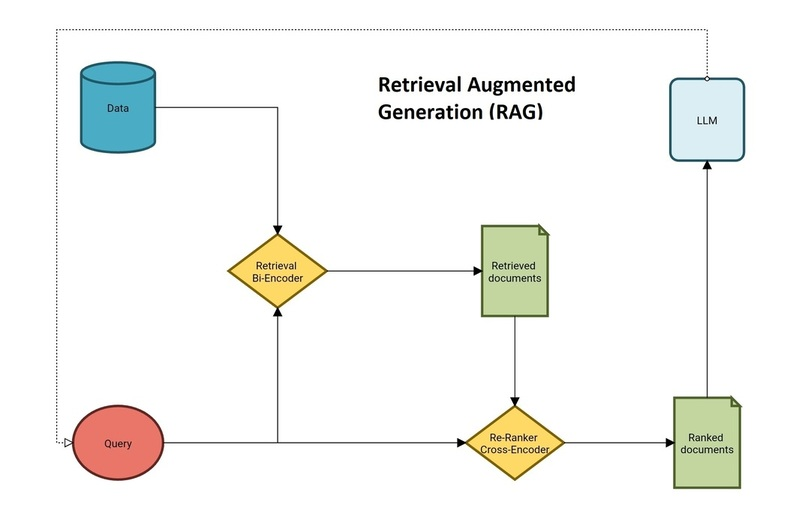

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter Notebook tool of your choice.
</div>

## Set up the environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
# %pip install --upgrade pip
%pip install argilla -qqq
%pip install datasets
%pip install sentence-transformers
%pip install farm-haystack[colab,faiss,inference]

Let's make the needed imports:

In [ ]:
import argilla as rg
from argilla.feedback import TrainingTask
from argilla.feedback import ArgillaTrainer

import random
import locale

from datasets import load_dataset
from tqdm import tqdm

from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import PreProcessor
from haystack.nodes import TextConverter
from haystack.nodes import EmbeddingRetriever
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser
from haystack.pipelines import Pipeline

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="owner.apikey",
    workspace="admin"
)

## The Dataset

The available datasets for sentence similarity can be of various types: pairs of positive similar sentences ([Sentence Compression](https://huggingface.co/datasets/embedding-data/sentence-compression)), for NLI ([snli](https://huggingface.co/datasets/snli)), with a label for the sentence ([QQP_triplets](https://huggingface.co/datasets/embedding-data/QQP_triplets)), etc. You can find more information about the different types of datasets [here](https://huggingface.co/blog/how-to-train-sentence-transformers)

In this example, we want to create a dataset with our own data. So, we will use the generative QA pipeline with RAG of Haystack to get the answers and context from a knowledge base. Then, we will upload it to Argilla using the `FeedbackDatasetTemplates` to work in the Argilla UI.



### Generating responses with Haystack

First, we download from HuggingFace the following [dataset](https://huggingface.co/datasets/argilla/cloud_assistant_questions) with questions about the Argilla Cloud which was created in this [tutorial](../../tutorials/feedback/fine-tuning-openai-rag-feedback.html). And then, we download the text file for RAG.

In [ ]:
# Load the questions
dataset = load_dataset("argilla/cloud_assistant_questions")

# Download the document for RAG
# locale.getpreferredencoding = lambda: "UTF-8" # Run it if UTF-8 encoding error
!curl https://huggingface.co/datasets/argilla/cloud_assistant_questions/raw/main/argilla_cloud.txt > argilla_cloud.txt

Now, let's preprocess our document using the predifined [`TextIndexingPipeline`](https://docs.haystack.deepset.ai/docs/ready_made_pipelines#textindexingpipeline). This pipeline allow us to initialize the ``DocumentStore`` (the database for the retriever), the ``PreProcessor`` (to clean and split the documents into smaller units), and the ``TextConverter`` (to convert the txt file into a Document object)

In [ ]:
# Initialize the DocumentStore
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat")

# Initialize the PreProcessor
preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=100,
    split_respect_sentence_boundary=True,
)

# Initialize the TextConverter
text_converter = TextConverter()

# Run the TextIndexingPipeline
pipeline = TextIndexingPipeline(document_store, text_converter, preprocessor)
result = pipeline.run(file_path="argilla_cloud.txt")

After having our file prepared, we initialize the retriever and prompt node and run the QA pipeline. In our case, we will use a dense retriever, ``EmbeddingRetriever``, which computes the embeddings of our document and those of the query. Regarding the [``PromptNode``](https://docs.haystack.deepset.ai/docs/prompt_node), we will use the [``flan-t5-large``](https://huggingface.co/google/flan-t5-large) model, although [more](https://docs.haystack.deepset.ai/docs/prompt_node#models) can be used. 

```python
# Use this code if you prefer to use the OpenAI API for the prompt node
# Remember to add your OpenAI API key for generation
prompt_node = PromptNode(
    model_name_or_path="text-davinci-003", api_key='api_key', default_prompt_template=rag_prompt
)
```

For more information, check the [documentation](https://docs.haystack.deepset.ai/docs/pipelines#querying-pipelines).

In [ ]:
# Initialize the EmbeddingRetriever
retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)
document_store.update_embeddings(retriever)

# Write the prompt for RAG
rag_prompt = PromptTemplate(
    prompt="""Provide a clear, natural and concise response.
                Your answer should be in your own words and be no longer than 50 words.
                \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
    output_parser=AnswerParser(),
)

# Initialize PromptNode
prompt_node = PromptNode(model_name_or_path="google/flan-t5-large", default_prompt_template=rag_prompt)

In [ ]:
# Create the pipeline
pipe = Pipeline()
pipe.add_node(component=retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])

# Run the pipeline
questions = dataset["train"]["question"]
answers = []
contexts = []

for question in tqdm(questions):
    
    # Get the response and save it
    response = pipe.run(query=question)
    answers.append(response["answers"][0].answer)
    
    # Get the document context and save it
    prompt = response["answers"][0].meta['prompt']
    start_index = prompt.find("Related text:") + len("Related text:")
    end_index = prompt.find("\n\n Question:")
    contexts.append(prompt[start_index:end_index].strip())

In [ ]:
print(f"Question: {questions[0]}")
print(f"Answer: {answers[0]}")
print(f"Context: {contexts[0]}")

### Create the Argilla dataset

Finally, we got our raw data, so we can create the Argilla dataset using the [`FeedbackDatasetTemplates`](LINK). In this case, we will use the ``FeedbackDataset.for_retrieval_augmented_generation`` template and leave the by default parameters (EXPLAIN).

In [ ]:
# Initialize the FeedbackDatasetTemplate
dataset = rg.FeedbackDataset.for_retrieval_augmented_generation(
    number_of_retrievals=1,
    rating_scale=10,
    use_markdown=False,
    guidelines=None,
)
dataset

# Adding records to the dataset
records = [
    rg.FeedbackRecord(
        fields={"query": question, "retrieved_document_1": context},
        suggestions=[
            {
                "question_name": "response",
                "value": answer,
            }
        ]
    )
    for question, answer, context in tqdm(zip(questions, answers, contexts), total=len(questions))
]

# Add records to the dataset
dataset.add_records(records)

In [ ]:
# Publish the dataset in the Argilla UI
dataset = dataset.push_to_argilla(name="my_rag_dataset", workspace="admin")

[ADD PHOTO]

## Fine-tuning the sentence similarity model

To improve the retrieval model, we need to [fine-tune a sentence similarity model](../../practical_guides/fine_tune.html#sentence-similarity), which compares the query embeddings and the context embeddings of the documents retrieved. This way, we can improve the results.

### Preparing the data for fine-tuning

First, we will prepare the data for fine-tuning. In our ``TrainingTask.for_sentence_similarity``, there will compare only two sentences: the query and the context. But this can be configured using a ``formatting_func``.

In [35]:
# Load the dataset from Argilla
dataset = rg.FeedbackDataset.from_argilla("my_rag_dataset", workspace="admin")

In [38]:
# Define the training task
task = TrainingTask.for_sentence_similarity(
    texts=[dataset.field_by_name("query"), dataset.field_by_name("context")]
)

### Fine-tuning the sentence similarity model

Using the ``ArgillaTrainer`` is really easy to fine-tune a sentence similarity model. We just need to initialize the trainer an call ``train``. To set if using the ``bi-encoder`` or the ``cross-encoder``, we just need to set ``framework_kwargs={"cross_encoder": False}`` or ``framework_kwargs={"cross_encoder": True}``.

> 💭 Remember that the ``cross-encoder`` can not be trained with triplets.

In [ ]:
# Fine-tune the bi-encoder
trainer_bi = ArgillaTrainer(
    dataset=dataset,
    task=task,
    framework="sentence-transformers",
    framework_kwargs={"cross_encoder": False}
)
trainer_bi.train(output_dir="my_bi_sentence_transformer_model")

In [ ]:
# Fine-tune the cross-encoder
trainer_cross = ArgillaTrainer(
    dataset=dataset,
    task=task,
    framework="sentence-transformers",
    framework_kwargs={"cross_encoder": True}
)
trainer_cross.train(output_dir="my_cross_sentence_transformer_model")

# Evaluating our models

We are now in the final step and we can make predictions with our fine-tuned models using ``ArgillaTrainer`` directly. Look at the results!

In [ ]:
# Predict using the bi-encoder model
trainer_bi.predict(
    [
        "What are the benefits of choosing Argilla Cloud service over other cloud services?",
        ["The benefits of choosing Argilla Cloud service over other cloud services include advanced security measures, robust data backup and recovery protocols, flexible pricing options, dedicated customer support, and efficient onboarding process.",
         "This documents an overview of the Argilla Cloud service - a comprehensive Software as a Service (SaaS) solution for data labeling and curation.The service is specifically designed to meet the needs of businesses seeking a reliable, secure, and user-friendly platform for data management.The key components of our service include advanced security measures, robust data backup and recovery protocols, flexible pricing options, and dedicated customer support."]
    ]
)

In [ ]:
# Predict using the cross-encoder model
trainer_cross.predict(
    [
        "What are the benefits of choosing Argilla Cloud service over other cloud services?",
        ["The benefits of choosing Argilla Cloud service over other cloud services include advanced security measures, robust data backup and recovery protocols, flexible pricing options, dedicated customer support, and efficient onboarding process.",
         "This documents an overview of the Argilla Cloud service - a comprehensive Software as a Service (SaaS) solution for data labeling and curation.The service is specifically designed to meet the needs of businesses seeking a reliable, secure, and user-friendly platform for data management.The key components of our service include advanced security measures, robust data backup and recovery protocols, flexible pricing options, and dedicated customer support."]
    ]
)